In [1]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os
from matplotlib import pyplot as plt

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf

# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)

from mt2 import mt2

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2024-02-21 13:12:13.936028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
seed = 42  # set random seed
sampling = int(5e6)
# num_folds = 2
batch_size = 512
epochs = 512
learning_rate = 1e-4

In [3]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [4]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [5]:
# inputs -> observed params
Bxy = processor.process_CGLMP(data.CGLMP)[["Bxy"]]
lep_p = processor.process_part(data.LepP)
lep_m = processor.process_part(data.LepM)
dilep_kin = processor.process_dipart(data.LepP, data.LepM)
MET = processor.process_MET(data.MET)
mt = pd.DataFrame(
    {"mt": np.sqrt(np.sum(np.square(dilep_kin[["m", "px", "py"]]), axis=1))}
)
mT2 = pd.DataFrame(
    {
        "mT2": np.sqrt(
            mt2(
                lep_m["m"],
                lep_m["px"],
                lep_m["py"],  # Visible 1: mass, px, py
                lep_p["m"],
                lep_p["px"],
                lep_p["py"],  # Visible 2: mass, px, py
                MET["MET_px"],
                MET["MET_py"],  # Missing transverse momentum: x, y
                0,
                0,  # Invisible 1 mass, invisible 2 mass
            )
        )
    }
)
pta = pd.DataFrame(
    {
        "pta": np.sqrt(
            np.square(lep_p["pt"])
            + np.square(lep_m["pt"])
            + np.square(MET["MET_px"])
            + np.square(MET["MET_py"])
        )
    }
)
# vx = pd.DataFrame({"vx": mt + 0.3 * np.sqrt(dilep_kin["m"])})
lep_kin_deta = pd.DataFrame({"d_eta": np.abs(lep_p.iloc[:, -2] - lep_m.iloc[:, -2])})
lep_kin = pd.concat(
    [lep_p.iloc[:, :4], lep_m.iloc[:, :4], mt["mt"], pta["pta"]],
    axis=1,
)

mask = cut_pre

obs_kin = pd.concat(
    [
        MET.iloc[:, 1:3],
        lep_kin,
    ],
    axis=1,
)[mask]
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = Bxy[mask]
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

# del (processor, lep_p, lep_m, MET, dilep_kin, mt, vx)
# gc.collect()

obs_kin shape: (1378510, 12)
       MET_px     MET_py           E         px         py          pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

            E         px         py         pz         mt         pta  
7   43.361348  42.407754  -4.632000   7.767462  62.513416  117.035693  
9   70.592648  29.001777   1.896990 -64.332027  67.559621   88.233289  
10  90.238664 -23.868604  32.986602  80.530680  74.393166   69.683329  

int_kin shape: (1378510, 1)
         Bxy
7   -5.57360
9   18.68250
10   6.54512



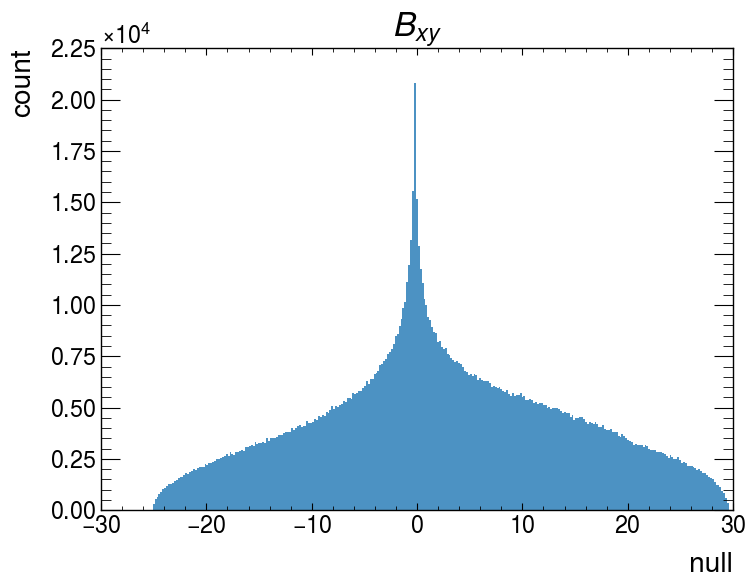

In [6]:
plt.hist(int_kin, bins=300, alpha=.8)
plt.title(r"$B_{xy}$")
plt.xlabel(r"null")
plt.ylabel("count")
plt.show()

In [7]:
SCALAR_int = StandardScaler()
int_kin = SCALAR_int.fit_transform(int_kin)

SCALAR_obs = StandardScaler()
obs_kin = SCALAR_obs.fit_transform(obs_kin)

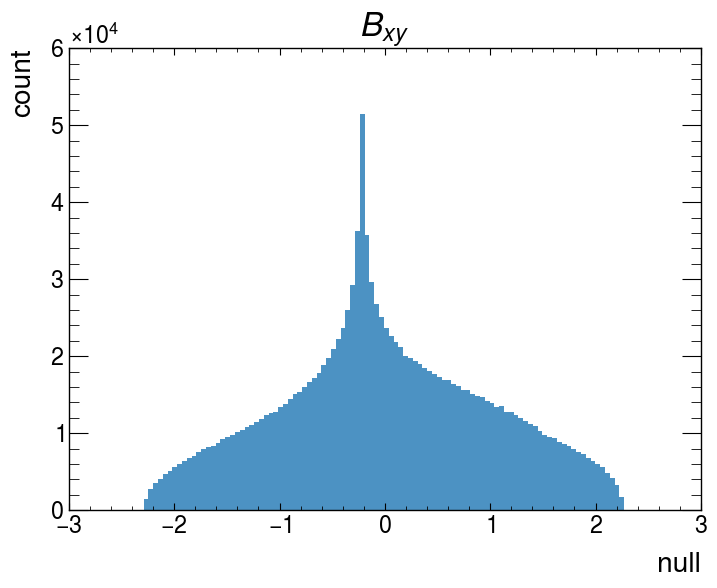

In [8]:
plt.hist(int_kin, bins=100, alpha=.8)
plt.title(r"$B_{xy}$")
plt.xlabel("null")
plt.ylabel("count")
# plt.xlim([0,0.5])
plt.show()

In [9]:
n = int(1e2)
step = (int_kin.max() - int_kin.min())/n
intervals = [int_kin.min() + i*step for i in range(n)]

sampling = int(1e3)
indices_arr = np.empty((n-1, sampling), dtype=int)
for i in range(n-1):
    try:
        indices_arr[i] = np.random.choice(np.where((intervals[i]<int_kin)*(int_kin<=intervals[i+1]))[0], size=sampling, replace=False)
    except ValueError:
        print("Cannot take a larger sample than population when 'replace=False")

In [10]:
# indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (39600, 12);
Validing data shape: (29700, 12);
Testing data shape: (29700, 12).
Y (Observed)
Training data shape: (39600, 1);
Validing data shape: (29700, 1);
Testing data shape: (29700, 1).



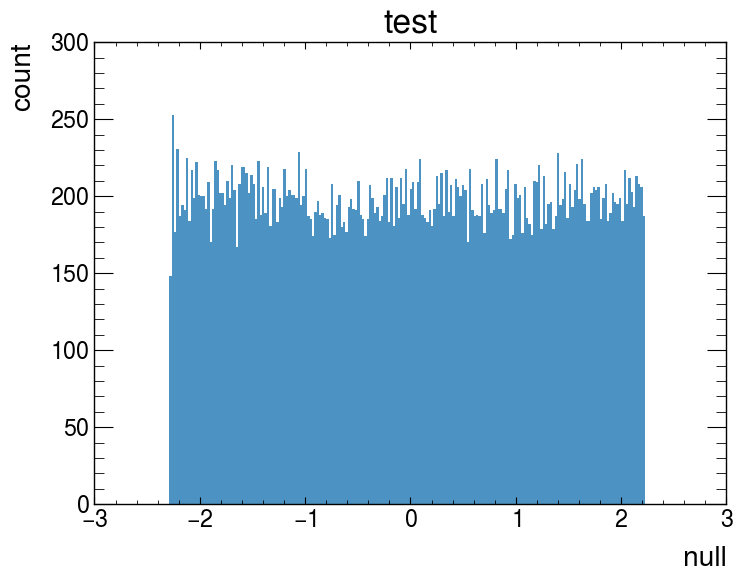

In [11]:
plt.hist(train_y, bins=200, alpha=.8)
plt.title(r"test")
plt.xlabel("null")
plt.ylabel("count")
# plt.xlim([0,0.5])
plt.show()

In [12]:
# Define a new activation function
def custom_activation(x):
    return x * tf.keras.backend.sigmoid(x)


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [13]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 4)                 68    

2024-02-21 13:12:30.084875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 445 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-02-21 13:12:30.085629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46252 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512


2024-02-21 13:12:31.767206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-21 13:12:31.770561: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f72f001bc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 13:12:31.770597: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-21 13:12:31.770610: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-21 13:12:31.779647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-21 13:12:31.916077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-21 13:12:32.03866

78/78 - 4s - loss: 1.7461 - val_loss: 1.6887 - 4s/epoch - 47ms/step
Epoch 2/512
78/78 - 0s - loss: 1.6992 - val_loss: 1.6584 - 435ms/epoch - 6ms/step
Epoch 3/512
78/78 - 0s - loss: 1.6728 - val_loss: 1.6323 - 445ms/epoch - 6ms/step
Epoch 4/512
78/78 - 0s - loss: 1.6474 - val_loss: 1.6061 - 440ms/epoch - 6ms/step
Epoch 5/512
78/78 - 0s - loss: 1.6221 - val_loss: 1.5787 - 436ms/epoch - 6ms/step
Epoch 6/512
78/78 - 0s - loss: 1.5973 - val_loss: 1.5541 - 448ms/epoch - 6ms/step
Epoch 7/512
78/78 - 0s - loss: 1.5744 - val_loss: 1.5333 - 447ms/epoch - 6ms/step
Epoch 8/512
78/78 - 0s - loss: 1.5528 - val_loss: 1.5130 - 450ms/epoch - 6ms/step
Epoch 9/512
78/78 - 0s - loss: 1.5334 - val_loss: 1.4957 - 432ms/epoch - 6ms/step
Epoch 10/512
78/78 - 0s - loss: 1.5165 - val_loss: 1.4817 - 433ms/epoch - 6ms/step
Epoch 11/512
78/78 - 0s - loss: 1.5023 - val_loss: 1.4694 - 429ms/epoch - 6ms/step
Epoch 12/512
78/78 - 0s - loss: 1.4909 - val_loss: 1.4610 - 422ms/epoch - 5ms/step
Epoch 13/512
78/78 - 0s - l

In [15]:
# save model
model.save("DNN_modified_m.h5", save_format="h5", overwrite=True)
# predict
pred_y = model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

  1/929 [..............................] - ETA: 1:30

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 38/929 [>.............................] - ETA: 1s  

929/929 [==============================] - 1s 1ms/step


In [16]:
print(f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}, min: {np.min(sig_truth[:,0]):.3f}, max: {np.max(sig_truth[:,0]):.3f}")

Truth mean: -0.026, std: 1.298, min: -2.290, max: 2.226


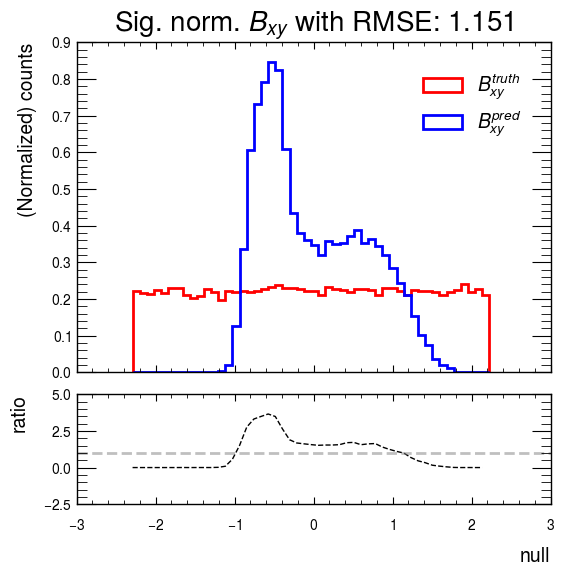

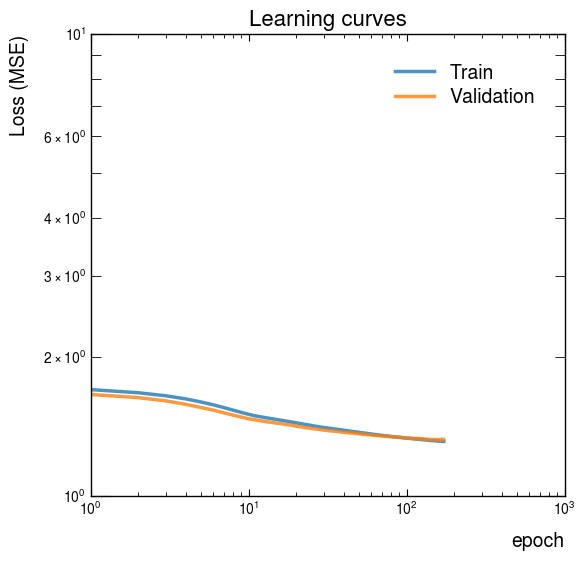

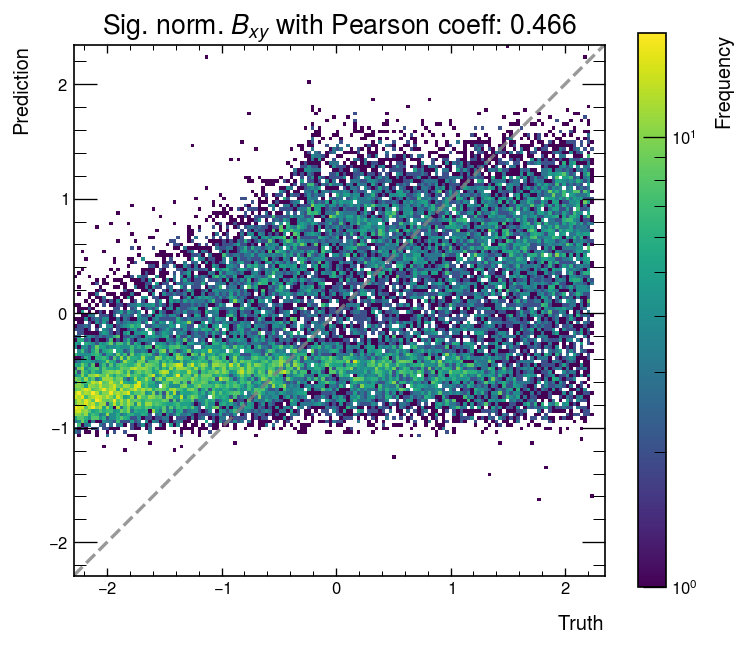

In [17]:
from sklearn.metrics import mean_squared_error

range = [-1.3, 2.4]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$B_{xy}^{truth}$", r"$B_{xy}^{pred}$"],
    r"Sig. norm. $B_{xy}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    # range=range,
    xlabel=r"null",
)

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Sig. norm. $B_{xy}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    # range=range,
)